In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.io import loadmat
import tensorflow as tf
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, MaxPool2D, LeakyReLU

In [2]:
joint_name = ['HeadF', 'HeadB', 'HeadL', 'SpineF', 'SpineM', 'SpineL', 
            'Offset1', 'Offset2', 'HipL', 'HipR', 'ElbowL', 'ArmL', 
            'ShoulderL', 'ShoulderR', 'ElbowR', 'ArmR', 'KneeR', 
            'KneeL', 'ShinL', 'ShinR']

joints_idx = [[1, 2], [2, 3], [1, 3], [2, 4], [1, 4], [3, 4], [4, 5], 
            [5, 6], [4, 7], [7, 8], [5, 8], [5, 7], [6, 8], [6, 9], 
            [6, 10], [11, 12], [4, 13], [4, 14], [11, 13], [12, 13], 
            [14, 15], [14, 16], [15, 16], [9, 18], [10, 17], [18, 19], 
            [17, 20]]

In [3]:
# Loading mat file and returning file
def loadMatFile(fileName):
    mat = loadmat('trainTestSplit.mat')[fileName]
    return mat

In [4]:
# Plot 3D points given file and frame number
def plotKnownOrder(matFile, numb):
    mat = matFile[numb]
    x = mat[0]
    y = mat[1]
    z = mat[2]

    # loading plot
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    # adding points, labels and lines
    try:
        ax.scatter(x,y,z, color='#ff5e5e', s =10, marker='x')
    except:
        pass
    # addLabels(ax, x, y, z)
    drawLines(ax, x, y, z)
    drawAllLines(ax, x, y, z)

    # Labeling plot
    ax.set_title("Rat positioning")
    ax.set_xlabel("X axis")
    ax.set_ylabel("Y axis")
    ax.set_zlabel("Z axis")
    plt.show()

# Draw major lines in the rat model
def drawLines(ax,x, y, z):
    # run through all the connections to draw the points
    for i in range(len(joints_idx)):
        try: 
            # Getting both points to draw line
            idx = joints_idx[i]
            x_line = [x[idx[0]-1], x[idx[1]-1]]
            y_line = [y[idx[0]-1], y[idx[1]-1]]
            z_line = [z[idx[0]-1], z[idx[1]-1]]
            z_coord_1 = x[idx[0]-1], y[idx[0]-1], z[idx[0]-1]
            z_coord_2 = x[idx[1]-1], y[idx[1]-1], z[idx[1]-1]

            # Draw lines
            if i < 3: 
                ax.plot(x_line, y_line, z_line, c="#064ea1", linewidth=4)
            elif i < 6:
                ax.plot(x_line, y_line, z_line, c="#64ccd1", linewidth=4)
            else:
                ax.plot(x_line, y_line, z_line, c="#46b8a7", linewidth=4)
        except:
            pass

# Draw all line from every point 
def drawAllLines(ax,x, y, z):
    joint_len = len(joint_name)
    all_lines = []
    distance = []

    for i in range(joint_len):
        point_dist = []
        for j in range(joint_len):
            point_dist.append(measureDistance(x[i], y[i], z[i], x[j], y[j], z[j]))
            if (not([i,j] in all_lines)):
                x_line = [x[i], x[j]]
                y_line = [y[i], y[j]]
                z_line = [z[i], z[j]]
                ax.plot(x_line, y_line, z_line, color='#b1d8fc', linewidth=0.5)
                all_lines.append([i,j])
                all_lines.append([j,i])
        distance.append(point_dist)
    return distance

In [5]:
# Get the distance to every single point 
def getAllDistances(matFile, numb, showMatrix):
    joint_len = len(joint_name)
    mat = matFile[numb]
    x = mat[0]
    y = mat[1]
    z = mat[2]
    distance = []

    for i in range(joint_len):
        point_dist = []
        for j in range(joint_len):
            if np.nan in [x[i], y[i], z[i], x[j], y[j], z[j]]:
                point_dist.append(np.nan)
            else:
                point_dist.append(measureDistance(x[i], y[i], z[i], x[j], y[j], z[j]))
        distance.append(point_dist)

    # normalizes distance data
    distance = normalize(distance)

    # Displays heat map 
    if (showMatrix == 1):
        ax = heatMap(distance)
        ax.set_title("Distance Matrix")
        ax.set_xlabel("Distance from POI to other points")
        ax.set_ylabel("Point of interest (POI)")
    return distance

# Gets the distance in a 3D coordinate system of 2 points
def measureDistance(x_1, y_1, z_1, x_2, y_2, z_2):
    x = (x_1 - x_2)
    y = (y_1 - y_2)
    z = (z_1 - z_2)
    return float(np.sqrt(x**2 + y**2 + z**2))

# Displays a heat map of inputed array
def heatMap(array):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.imshow(array, cmap='YlOrRd') 
    plt.colorbar()
    plt.grid(False)
    return ax

In [6]:
# normalizes a matrix
def normalize(matrix):
    matrix = np.array(matrix)
    norm = []
    max_numb = max(matrix[~np.isnan(matrix)])

    for i in range(len(matrix)):
        norm_line = []
        for j in range(len(matrix[i])):
            if np.isnan(matrix[i][j]):
                norm_line.append(np.nan)
            else:
                norm_line.append(matrix[i][j]/max_numb)
        norm.append(norm_line)
    return norm

In [7]:
# Get the absolute height difference to every single point 
def getAllHeights(matFile, numb, showMatrix):
    joint_len = len(joint_name)
    mat = matFile[numb]
    z = mat[2]
    height = []

    for i in range(joint_len):
        point_dist = []
        for j in range(joint_len):
            if np.nan in [z[i], z[j]]:
                point_dist.append(np.nan)
            else:
                point_dist.append(np.abs(z[i]-z[j]))
        height.append(point_dist)

    # normalizes height data
    height = normalize(height)

    # Displays heat map 
    if (showMatrix == 1 or showMatrix == 3):
        ax = heatMap(height)
        ax.set_title("Height Matrix")
        ax.set_xlabel("Distance from POI to other points")
        ax.set_ylabel("Point of interest (POI)")

    # if (showMatrix == 2 or showMatrix == 3):
    #     ax = heatMap(height)
    #     ax.set_title("Sorted Height Matrix")
    #     ax.set_xlabel("Distance from POI to other points")
    #     ax.set_ylabel("Point of interest (POI)")
    return height


In [8]:
# Get the angle to every single point 
def getAllAngles(matFile, numb, showMatrix):
    joint_len = len(joint_name)
    mat = matFile[numb]
    x = mat[0]
    y = mat[1]
    z = mat[2]
    angle = []

    for i in range(joint_len):
        point_dist = []
        for j in range(joint_len):
            ref_point = [x[i], y[i], z[i]]
            target_point = [x[j], y[j], z[j]]
            contain_none = (np.nan in target_point) or (np.nan in ref_point)
            if (np.array_equal(ref_point, target_point)) or (contain_none):
                point_dist.append(np.nan)
            else:
                point_dist.append(getAngles(np.array(ref_point), np.array(target_point)))
        angle.append(point_dist)

    # normalizes distance data
    angle = normalize(angle)

    # Displays heat map 
    if (showMatrix == 1 or showMatrix == 3):
        ax = heatMap(angle)
        ax.set_title("Angle Matrix")
        ax.set_xlabel("Distance from POI to other points")
        ax.set_ylabel("Point of interest (POI)")

    # if (showMatrix == 2 or showMatrix == 3):
    #     ax = heatMap(angle)
    #     ax.set_title("Sorted Angle Matrix")
    #     ax.set_xlabel("Distance from POI to other points")
    #     ax.set_ylabel("Point of interest (POI)")

    return angle

def getAngles(a, b):
    c = np.array([b[0], b[1], a[2]])
    ab = a - b
    ac = a - c
    cosine = np.dot(ab, ac) / (np.linalg.norm(ab) * np.linalg.norm(ac))
    angle = np.arccos(cosine)
    return np.degrees(angle)

In [9]:
def getTrainingLabels(numb):
    point_labels = np.arange(0, len(joint_name))
    all_labels = np.tile(point_labels, numb)
    return all_labels


In [10]:
# Make training data out of clean data
def getTrainingData(mat, traningNumb):
    raw = mat[:traningNumb]
    raw_copy = np.array(raw.copy())

    for i in range(raw_copy.shape[0]):
        rand_numb = np.random.randint(1, 4)
        rand_index = random.sample(range(3, 20), rand_numb)
        for j in range(rand_numb):
            raw_copy[i][:,rand_index[j]] = np.nan
    return raw_copy

def getTestingData(mat, testingNumb):
    raw = mat[:testingNumb]
    test_data = []
    for i in range(len(raw)):
        temp_test = []
        for j in range(len(raw[i])):
            temp_test.append(np.sort(raw[i][j]))
        test_data.append(temp_test)
    return test_data
    

In [11]:
# Major function that gets the data
def getData(matFile, traningNumb, showMatrix, training):
    mat = loadMatFile(matFile)
    print("Loaded file:", matFile)
    traning_labels = getTrainingLabels(traningNumb)

    cnn_inputs = []
    # if we are collecting training data, create training data
    if training:
        mat = getTrainingData(mat, traningNumb)
    else: 
        mat = mat[traningNumb]
    
    for i in range (traningNumb):
        # plotKnownOrder(mat, i)
        dist = getAllDistances(mat, i, showMatrix)  
        height = getAllHeights(mat, i, showMatrix)
        angle = getAllAngles(mat, i, showMatrix)
        # cnn_inputs.append([dist, height, angle])
        for j in range(0, len(joint_name)):
            temp = np.array([dist[j], height[j], angle[j]])
            first = temp[:,0:3]
            second = temp[:,3:20]
            first = first [ :, first[0].argsort()]
            # first = np.ones((3,3))
            second = second [ :, second[0].argsort()]
            # second = second[:,3:13]
            output = np.concatenate((first, second), axis =1)
            # print(output.shape)
            cnn_inputs.append(output)
    # change
    cnn_inputs = np.array(cnn_inputs)[:,:,:13]
    cnn_inputs = np.array(cnn_inputs).reshape((traningNumb*20, 39))
    # return_cnn = cnn_inputs.reshape((20*traningNumb), -1)#[:,:,:13]

    where_are_NaNs = np.isnan(cnn_inputs)
    cnn_inputs[where_are_NaNs] = 0
    return cnn_inputs, traning_labels

In [12]:
# train_data, train_labels = getData('split1True', 10, 0, True)
# print(train_data.shape)
# plt.imshow(train_data[19].reshape(3,13))

In [13]:
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, MaxPool2D, LeakyReLU, LocallyConnected1D
# Creates the ML training platform to predict rat joints
def ml_traning(train_data, train_labels, test_data, test_labels):
    # change
    train_data = train_data.reshape(train_data.shape[0], 39)
    test_data = test_data.reshape(test_data.shape[0], 39)
    train_data = train_data.astype('float32')
    test_data = test_data.astype('float32')

    model = createModel()
    model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])
    model.fit(x=train_data,y=train_labels, verbose=1, batch_size=20, epochs=50)
    
    output = model.evaluate(test_data, test_labels)
    print("Loss:", output[0])
    print("Accuracy:", output[1])

    return model

# Creates the model for the CNN
def createModel():
    model = Sequential()

    # model.add(Dense(640, activation= LeakyReLU()))
    # model.add(Dense(320, activation= LeakyReLU()))
    # model.add(Dropout(rate=0.25))
    # model.add(Dense(320, activation= LeakyReLU()))
    # model.add(Dense(160, activation= LeakyReLU()))
    # model.add(Dropout(rate=0.25))
    # model.add(Dense(80, activation= LeakyReLU()))
    model.add(Dense(320, activation= "relu"))
    model.add(Dense(320, activation= "relu"))
    model.add(Dense(320, activation= "relu"))
    model.add(Dense(20, activation = "softmax"))
    return model

# Displays what one of the inputs looks likes
def inputExample(train_data, train_labels):
    image_index =  1
    print(train_labels[image_index]) 
    plt.imshow(train_data[image_index])

In [14]:
traning_numb = 500
testing_numb = 500
train_data, train_labels = getData('split1True', traning_numb, 0, True)
test_data, test_labels = getData('split2True', testing_numb, 0, True)

Loaded file: split1True
Loaded file: split2True


(10000, 39)
(10000,)


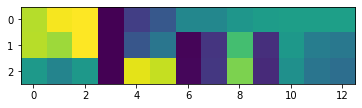

In [15]:
print(train_data.shape)
print(test_labels.shape)
# change
plt.imshow(train_data[19].reshape(3,13))

In [16]:
skeleton_model = ml_traning(train_data, train_labels, test_data, test_labels)

Epoch 1/50
500/500 [==============================] - 2s 3ms/step - loss: 1.3599 - accuracy: 0.5254
Epoch 2/50
500/500 [==============================] - 1s 2ms/step - loss: 0.9059 - accuracy: 0.6869
Epoch 3/50
500/500 [==============================] - 1s 2ms/step - loss: 0.7755 - accuracy: 0.7322
Epoch 4/50
500/500 [==============================] - 1s 3ms/step - loss: 0.7143 - accuracy: 0.7526
Epoch 5/50
500/500 [==============================] - 1s 2ms/step - loss: 0.6581 - accuracy: 0.7752
Epoch 6/50
500/500 [==============================] - 1s 3ms/step - loss: 0.6079 - accuracy: 0.7897
Epoch 7/50
500/500 [==============================] - 1s 2ms/step - loss: 0.5885 - accuracy: 0.8018
Epoch 8/50
500/500 [==============================] - 1s 3ms/step - loss: 0.5535 - accuracy: 0.8110
Epoch 9/50
500/500 [==============================] - 1s 2ms/step - loss: 0.5333 - accuracy: 0.8165
Epoch 10/50
500/500 [==============================] - 1s 3ms/step - loss: 0.5196 - accuracy: 0.8208

In [23]:
# Showing individual predictions
def predict(image_index, model):
    img = test_data[image_index]
    # change
    plt.imshow(img.reshape(3,13))
    plt.show()
    
    img = np.array(img.reshape(1, 39))
    pred = model.predict(img)
    predict = pred.argmax()
    actual = test_labels[image_index]

    print("Actual", actual)
    print("Predicted", predict)
    
    if predict == actual:
        print("YAY ✿(ᵔ‿ᵔ)")
    else:
        print("Wrong (◕︵◕)")
        
# Tests individual points and tells you if the CNN worked
def handTestModel(predict_index):
    max_index = len(joint_name*testing_numb)-1
    if predict_index <= max_index:
        predict(predict_index, skeleton_model)
    else:
        print("ERROR: Your predict_index must be below", max_index)

# Shows example of tain_data and test_data
def example(train_data, test_data, testnumb):
    print(train_data.shape)
    print(test_data.shape)
    example_train = [train_data[testnumb]]
    example_test = [test_data[testnumb]]
    fig, ax = plt.subplots(2,1, figsize=(10,2))
    ax[0].imshow(example_train, aspect="auto")
    ax[1].imshow(example_test, aspect="auto")
    ax[0].set_title("Example of train and test data")

def show_input_example(numb):
    # Showing what split files look like
    mat = loadMatFile('split2')
    print("Loaded file:", 'split2')
    mat = mat[:numb]
    fig_1, ax_1 = plt.subplots(numb,1, figsize=(20,5))
    for i in range(len(mat)):
        output = np.squeeze(mat[i])
        ax_1[i].imshow(output)
    ax_1[0].set_title("split2 data")
    plt.show()

    # Showing what splitTrue files look like after I remove random points
    mat = loadMatFile('split1True')
    output = getTrainingData(mat, numb)
    fig_2, ax_2 = plt.subplots(numb,1, figsize=(20,5))
    for i in range(len(output)):
        ax_2[i].imshow(output[i])
    ax_2[0].set_title("Processed split1True data")
    plt.show()
    

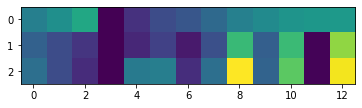

Actual 6
Predicted 6
YAY ✿(ᵔ‿ᵔ)


In [18]:
handTestModel(6)

(10000, 39)
(10000, 39)
Loaded file: split2


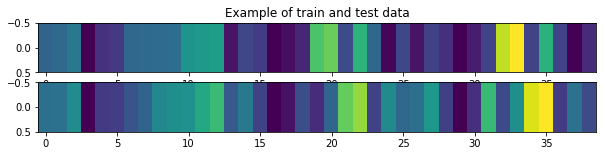

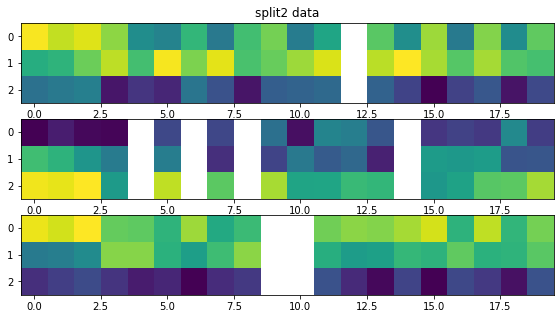

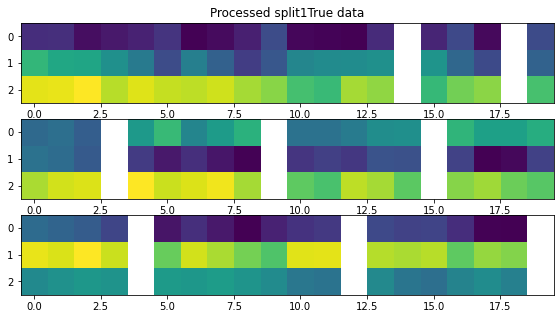

In [19]:
example(train_data, test_data, 123)
show_input_example(3)

In [20]:
def loadMat(matFile):
    mat = loadMatFile(matFile)
    print("Loaded file:", matFile)
    return mat

# Showing individual predictions for unlabeled image
def blindPredict(mat, model, image_index):
    image_index = image_index/20
    frame = int(image_index)
    index = (20 *(image_index % 1))
    index = int(index)
    print("Frame", frame)
    print("Index", index)
    cnn_inputs = []
    dist = getAllDistances(mat, frame, 0)  
    height = getAllHeights(mat, frame, 0)
    angle = getAllAngles(mat, frame, 0)

    temp = np.array([dist[index], height[index], angle[index]])
    plt.imshow(temp)
    plt.show()
    first = temp[:,0:3]
    second = temp[:,3:20]
    first = first [ :, first[0].argsort()]
    second = second [ :, second[0].argsort()]
    # change
    output = np.concatenate((first, second), axis =1)[:,:13]
    plt.imshow(output)
    plt.show()

    cnn_inputs = np.array(output)
    where_are_NaNs = np.isnan(cnn_inputs)
    cnn_inputs[where_are_NaNs] = 0

   # change
    plt.imshow(cnn_inputs.reshape(3,13))
    plt.show()

    cnn_inputs = cnn_inputs.reshape(1, 39)
    pred = model.predict(cnn_inputs)
    predict = pred.argmax()
    print("Predicted", predict)


In [21]:
mat = loadMat('split2')

Loaded file: split2


Frame 3
Index 0


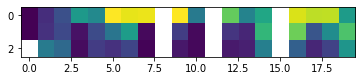

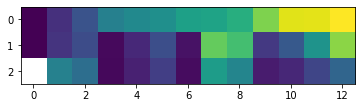

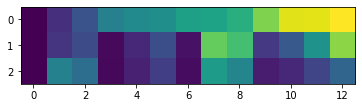

Predicted 0


In [22]:
blindPredict(mat, skeleton_model, 60)